In [176]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn import metrics

import numpy as np
import pandas as pd
import re
import itertools
import csv

In [232]:
# One column
# p30_u10 - configuration key: Percentile 30, Uniformity 10
# nature - model type: nature, urban or all
# all - dataset type: nature, urban or all
# 0.6424242854118347 - loss value for picture 0
# 15 more float values for 15 more pictures
df_losses = pd.read_csv('model_predictions.csv')
# One column
# p30_u10 - configuration key: Percentile 30, Uniformity 10
# all - dataset type: nature, urban or all
# 0.6424242854118347 - actual value for picture 0
# 15 more float values for 15 more pictures
df_actual = pd.read_csv('image_actuals.csv')

In [233]:
for col in df_losses.columns:
    #remove generated index from col_name
    col_name = re.sub('\.\d$', '', col)
    # get first and second rows values for this specific column
    first_row = df_losses.iloc[0][col]
    second_row = df_losses.iloc[1][col]
    #new name of this column
    new_column_name = f"{col_name}_{first_row}_{second_row}"
    # rename the column with the existing column header plus the first 2 rows of that column's data
    df_losses.rename(columns={col: new_column_name}, inplace=True)

# delete first 2 rows of data, now that it's merged into the header
df_losses.drop(index=[0,1], inplace=True)
df_losses.drop(columns=df_losses.columns[0], axis=1, inplace=True)
df_losses.reset_index(drop=True, inplace=True)
df_losses=df_losses.astype(float)

for col in df_actual.columns:
    #remove generated index from col_name
    col_name = re.sub('\.\d$', '', col)
    # get first row value for this specific column
    first_row = df_actual.iloc[0][col]
    #new name of this column
    new_column_name_2 = f"{col_name}_{first_row}"
    # rename the column with the existing column header plus the first row of that column's data
    df_actual.rename(columns={col: new_column_name_2}, inplace=True)

# delete first row of data, now that it's merged into the header
df_actual.drop(index=[0], inplace=True)
df_actual.drop(columns=df_actual.columns[0], axis=1, inplace=True)
df_actual.reset_index(drop=True,inplace=True)
df_actual=df_actual.astype(float)

In [236]:
#True classsification, based on the original values, if that > 0.5 new value = 1, else new value = 0
df_losses_true = pd.DataFrame(df_losses.copy(), index=df_losses.index, columns=df_losses.columns)
df_actual_true = pd.DataFrame(df_actual.copy(), index=df_actual.index, columns=df_actual.columns)
for col in df_losses_true.columns:
  df_losses_true.loc[df_losses_true[col] > 0.5, col] = 1
  df_losses_true.loc[df_losses_true[col] <= 0.5, col] = 0
for col in df_actual_true.columns:
  df_actual_true.loc[df_actual_true[col] > 0.5, col] = 1
  df_actual_true.loc[df_actual_true[col] <= 0.5, col] = 0

In [238]:
#percent_uniform, model and dataset possible values sets
#for model predicted-actual values separation
test_type_keys = {
    'percent_uniform': set(),
    'model': set(),
    'dataset': set()
}
for name in df_losses_true.columns:
  type_values = name.split('_')
  test_type_keys['percent_uniform'].add(type_values[0]+"_"+type_values[1])
  test_type_keys['model'].add(type_values[2])
  test_type_keys['dataset'].add(type_values[3])
for name in df_actual_true.columns:
  type_values = name.split('_')
  test_type_keys['percent_uniform'].add(type_values[0]+"_"+type_values[1])
  test_type_keys['dataset'].add(type_values[2])

In [239]:
def first_2_split(text):
  text_splitted = text.split('_')[0:2]
  return text_splitted[0]+"_"+text_splitted[1]

In [240]:
#Prediction and actual lists for all configuration and model combination
#(Dataset tests are combined)
losses_models_names = []
actual_image_names = []
for f in test_type_keys['model']:
  losses_combinations = [f"{l[0]}_{l[1]}_{l[2]}" for l in list(itertools.product(test_type_keys['percent_uniform'], [f], test_type_keys['dataset']))]
  actuals_combinations = [f"{l[0]}_{l[2]}" for l in list(itertools.product(test_type_keys['percent_uniform'], [f], test_type_keys['dataset']))]
  for key, group in itertools.groupby(losses_combinations, first_2_split):
    losses_models_names.append(np.array(list(group)))
  for key, group in itertools.groupby(actuals_combinations, first_2_split):
    actual_image_names.append(np.array(list(group)))

In [241]:
def confusion_matrix(actuals,losses):
  tn, fp, fn, tp  = metrics.confusion_matrix(actuals,losses).ravel() #roc_curve(test, pred, drop_intermediate=False)
  return tn, fp, fn, tp

In [242]:
#Intersection over Union
def IoU_score(tn, fp, fn, tp):
  IoU = tp / (tp+fn+fp)
  return IoU

In [243]:
#Sørensen–Dice
def DSC_score(tn, fp, fn, tp):
  DSC = (2*tp) / (2*tp+fn+fp)
  return DSC

In [310]:
#Scores of the models
score_table=[]
for i in range(min(len(losses_models_names),len(actual_image_names))):
  losses = np.array(df_losses_true[losses_models_names[i]]).reshape(16*losses_models_names[i].size)
  actuals = np.array(df_actual_true[actual_image_names[i]]).reshape(16*actual_image_names[i].size)
  model_name_sep = df_losses_true[losses_models_names[i]].columns[0].split('_')
  model_name = model_name_sep[0]+"_"+model_name_sep[1]+"_"+model_name_sep[2]
  tn, fp, fn, tp=confusion_matrix(actuals,losses)
  tpr=tp/(tp+fn)
  IoU = IoU_score(tn, fp, fn, tp)
  DSC = DSC_score(tn, fp, fn, tp)
  score_table.append({'name':model_name, 'model': model_name_sep[2],
                      'tn': tn, 'fp': fp,
                      'fn': fn, 'tp': tp,
                      'tpr': tpr,
                      'IoU': IoU, 'DSC': DSC})
print(score_table)

[{'name': 'p70_u25_urban', 'model': 'urban', 'tn': 0, 'fp': 8, 'fn': 0, 'tp': 40, 'tpr': 1.0, 'IoU': 0.8333333333333334, 'DSC': 0.9090909090909091}, {'name': 'p50_u40_urban', 'model': 'urban', 'tn': 0, 'fp': 11, 'fn': 0, 'tp': 37, 'tpr': 1.0, 'IoU': 0.7708333333333334, 'DSC': 0.8705882352941177}, {'name': 'p30_u25_urban', 'model': 'urban', 'tn': 0, 'fp': 13, 'fn': 0, 'tp': 35, 'tpr': 1.0, 'IoU': 0.7291666666666666, 'DSC': 0.8433734939759037}, {'name': 'p70_u40_urban', 'model': 'urban', 'tn': 0, 'fp': 8, 'fn': 0, 'tp': 40, 'tpr': 1.0, 'IoU': 0.8333333333333334, 'DSC': 0.9090909090909091}, {'name': 'p50_u10_urban', 'model': 'urban', 'tn': 0, 'fp': 7, 'fn': 0, 'tp': 41, 'tpr': 1.0, 'IoU': 0.8541666666666666, 'DSC': 0.9213483146067416}, {'name': 'p30_u10_urban', 'model': 'urban', 'tn': 0, 'fp': 9, 'fn': 0, 'tp': 39, 'tpr': 1.0, 'IoU': 0.8125, 'DSC': 0.896551724137931}, {'name': 'p50_u25_urban', 'model': 'urban', 'tn': 0, 'fp': 11, 'fn': 0, 'tp': 37, 'tpr': 1.0, 'IoU': 0.7708333333333334, '

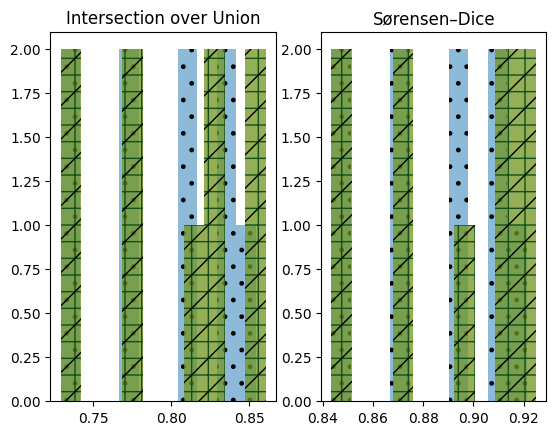

<Figure size 640x480 with 0 Axes>

In [313]:
figure, axis = plt.subplots(1,2)
axis[0].hist([i['IoU'] for i in score_table if i['model']=='all'], alpha=0.5, hatch = '.')
axis[0].hist([i['IoU'] for i in score_table if i['model']=='urban'], alpha=0.5, hatch = '+')
axis[0].hist([i['IoU'] for i in score_table if i['model']=='nature'], alpha=0.5, hatch = '/')
axis[0].set_title('Intersection over Union')
axis[1].hist([i['DSC'] for i in score_table if i['model']=='all'], alpha=0.5, hatch = '.')
axis[1].hist([i['DSC'] for i in score_table if i['model']=='urban'], alpha=0.5, hatch = '+')
axis[1].hist([i['DSC'] for i in score_table if i['model']=='nature'], alpha=0.5, hatch = '/')
axis[1].set_title('Sørensen–Dice')
plt.show()
plt.savefig(f'output/IoU_DSC.png')

In [ ]:
for conf in score_table:
  plt.figure()
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix =np.array([[conf['tn'], conf['fp']], [conf['fn'], conf['tp']]]), display_labels = [0, 1])
  cm_display.plot()
  plt.title(f'ConfusionMatrix for {conf["name"]}')
  plt.savefig(f'output/conf_matrix_{conf["name"]}.png')
  plt.show()

In [312]:
score_table_fields = ['name', 'model', 'tn', 'fp', 'fn', 'tp', 'tpr', 'IoU', 'DSC']
filename = "output/model_scores.csv"
with open(filename, 'w') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=score_table_fields)

    # writing headers (field names)
    writer.writeheader()

    # writing data rows
    writer.writerows(score_table)